# Naive Bayes - Seeds Dataset

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold, cross_val_predict

from utils import evaluate_cross_validation, evaluation, evaluation_all_features, discretize_dataset, print_score

## Dataset analysis

In [2]:
path = './data/seeds/seeds_dataset.txt'

feature_names = ['Area', 'Perimeter', 'Compactness', 'Length of kernel', 'Width of kernel',
                 'Asymmetry coefficient', 'Length of kernel groove']
class_names = ['Kama', 'Rosa', 'Canadian']
class_column_name = 'Wheat'

names = feature_names + ['y']
dataset = pd.read_csv(path, names=names, sep='\s+')
dataset['y'] = dataset['y'].apply(lambda x: x - 1)
dataset[class_column_name] = dataset['y'].apply(lambda x: class_names[x])

In [3]:
dataset.head()

Area  Perimeter  Compactness  Length of kernel  Width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   Asymmetry coefficient  Length of kernel groove  y Wheat  
0                  2.221                    5.220  0  Kama  
1                  1.018                    4.956  0  Kama  
2                  2.699                    4.825  0  Kama  
3                  2.259                    4.805  0  Kama  
4                  1.355                    5.175  0  Kama

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     210 non-null    float64
 1   Perimeter                210 non-null    float64
 2   Compactness              210 non-null    float64
 3   Length of kernel         210 non-null    float64
 4   Width of kernel          210 non-null    float64
 5   Asymmetry coefficient    210 non-null    float64
 6   Length of kernel groove  210 non-null    float64
 7   y                        210 non-null    int64  
 8   Wheat                    210 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 14.9+ KB


In [5]:
dataset[feature_names].describe()

Area   Perimeter  Compactness  Length of kernel  Width of kernel  \
count  210.000000  210.000000   210.000000        210.000000       210.000000   
mean    14.847524   14.559286     0.870999          5.628533         3.258605   
std      2.909699    1.305959     0.023629          0.443063         0.377714   
min     10.590000   12.410000     0.808100          4.899000         2.630000   
25%     12.270000   13.450000     0.856900          5.262250         2.944000   
50%     14.355000   14.320000     0.873450          5.523500         3.237000   
75%     17.305000   15.715000     0.887775          5.979750         3.561750   
max     21.180000   17.250000     0.918300          6.675000         4.033000   

       Asymmetry coefficient  Length of kernel groove  
count             210.000000               210.000000  
mean                3.700201                 5.408071  
std                 1.503557                 0.491480  
min                 0.765100                 4.519000  
25%                 2.561500                 5.045000  
50%                 3.599000                 5.223000  
75%                 4.768750                 5.877000  
max                 8.456000                 6.550000

In [6]:
dataset_numeric = dataset[feature_names]
dataset_numeric = dataset_numeric.apply(pd.to_numeric, errors='coerce')

In [7]:
dataset[dataset.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [Area, Perimeter, Compactness, Length of kernel, Width of kernel, Asymmetry coefficient, Length of kernel groove, y, Wheat]
Index: []

In [8]:
dataset[dataset.duplicated()].head()

Empty DataFrame
Columns: [Area, Perimeter, Compactness, Length of kernel, Width of kernel, Asymmetry coefficient, Length of kernel groove, y, Wheat]
Index: []

## Dataset preprocessisng

In [9]:
dataset.dropna(inplace=True)

In [10]:
dataset.drop_duplicates(inplace=True)

In [11]:
dataset[feature_names].describe()

Area   Perimeter  Compactness  Length of kernel  Width of kernel  \
count  210.000000  210.000000   210.000000        210.000000       210.000000   
mean    14.847524   14.559286     0.870999          5.628533         3.258605   
std      2.909699    1.305959     0.023629          0.443063         0.377714   
min     10.590000   12.410000     0.808100          4.899000         2.630000   
25%     12.270000   13.450000     0.856900          5.262250         2.944000   
50%     14.355000   14.320000     0.873450          5.523500         3.237000   
75%     17.305000   15.715000     0.887775          5.979750         3.561750   
max     21.180000   17.250000     0.918300          6.675000         4.033000   

       Asymmetry coefficient  Length of kernel groove  
count             210.000000               210.000000  
mean                3.700201                 5.408071  
std                 1.503557                 0.491480  
min                 0.765100                 4.519000  
25%                 2.561500                 5.045000  
50%                 3.599000                 5.223000  
75%                 4.768750                 5.877000  
max                 8.456000                 6.550000

## Dataset visualization

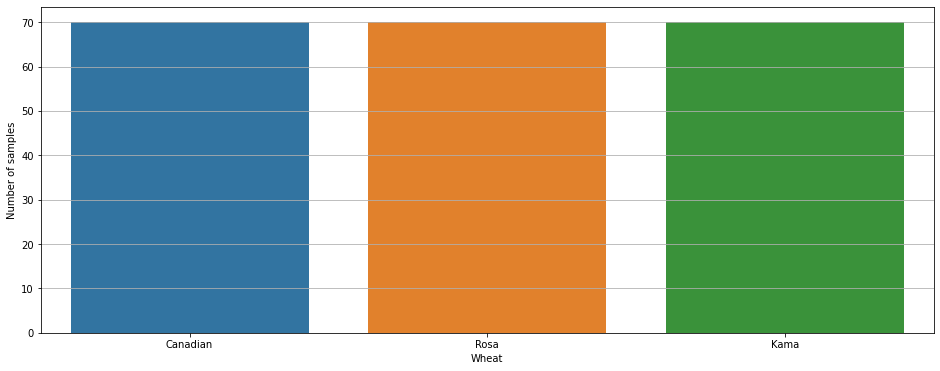

In [12]:
dataset_class_counts = dataset[class_column_name].value_counts()
plt.figure(figsize=(16, 6))
plt.grid(True)
plt.ylabel('Number of samples')
plt.xlabel(class_column_name)
sns.barplot(dataset_class_counts.index, dataset_class_counts.values)
plt.savefig('plots/seeds_class_dist.png')

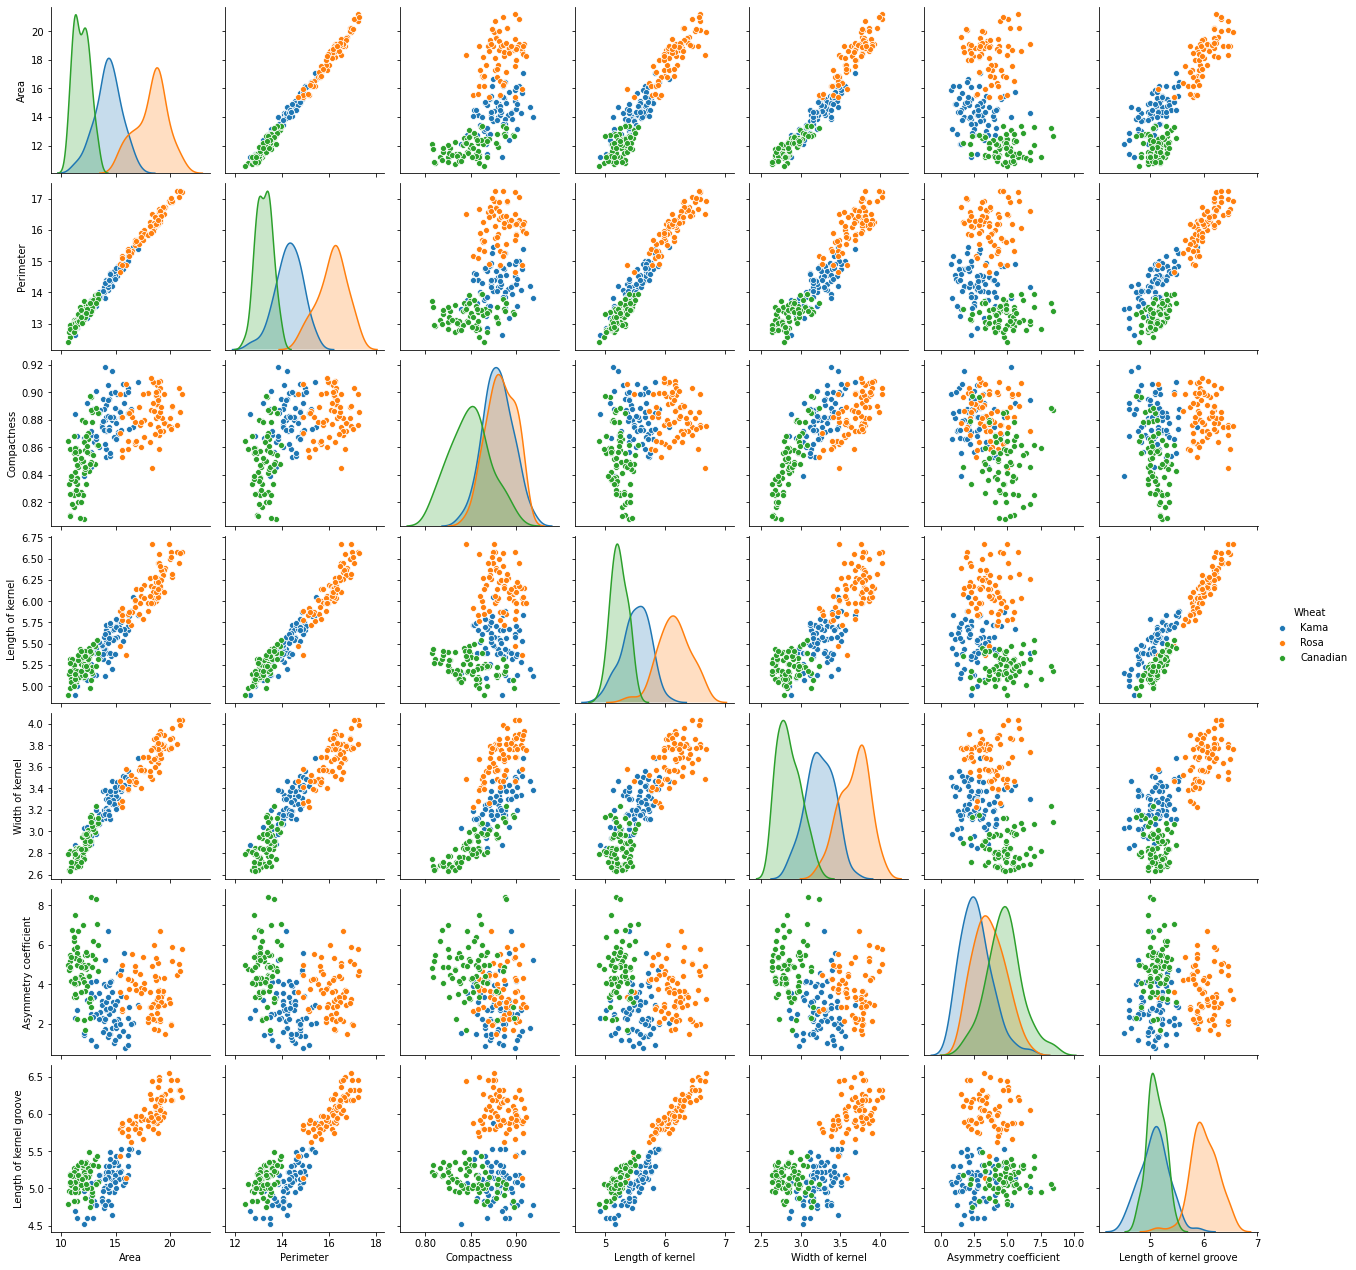

In [13]:
sns.pairplot(dataset, hue=class_column_name, vars=feature_names)
plt.savefig('plots/seeds_pairplot.png')

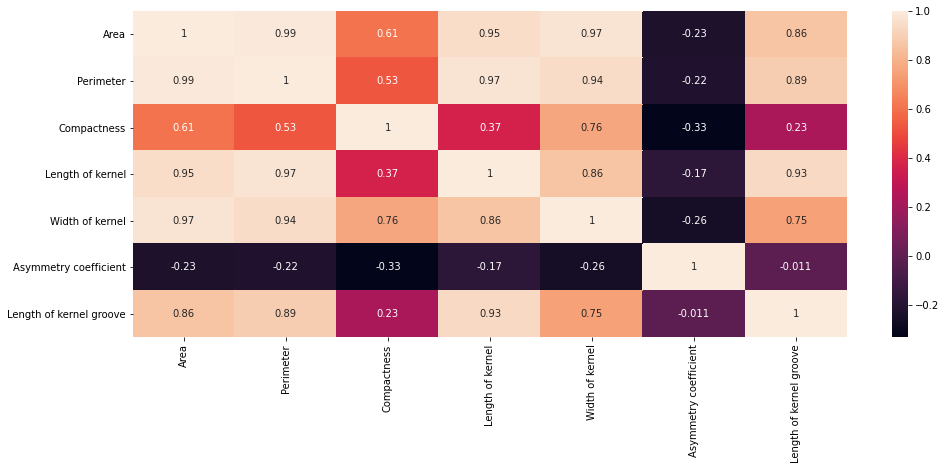

In [14]:
plt.figure(figsize=(16, 6))
sns.heatmap(dataset[feature_names].corr(), annot=True)
plt.savefig('plots/seeds_correlation.png')

## Model fitting

In [15]:
X, y = dataset[feature_names], dataset['y']

model_gnb = GaussianNB()

sk_fold = StratifiedKFold(n_splits=5, random_state=3, shuffle=True)
y_pred = cross_val_predict(model_gnb, X, y, cv=sk_fold)

print_score(y, y_pred)

Acc:           0.9
f1 avg:        0.8995445978983238
Recall avg:    0.9
Precision avg: 0.8998641730633944
Recall:        [0.82857143 0.92857143 0.94285714]
Precision:     [0.86567164 0.94202899 0.89189189]
f1:            [0.84671533 0.9352518  0.91666667]
Confusion matrix:
[[58  4  8]
 [ 5 65  0]
 [ 4  0 66]]


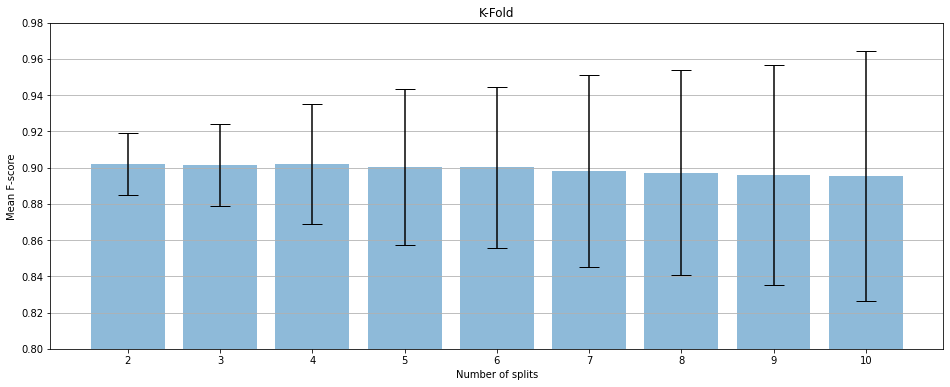

In [16]:
k_splits = list(range(2, 11))
results, errors = evaluate_cross_validation(model_gnb, X, y, KFold, k_splits)

_, ax = plt.subplots(figsize=(16, 6))
ax.bar(k_splits, results,
       yerr=errors,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Mean F-score')
ax.set_xlabel('Number of splits')
ax.set_xticks(k_splits)
ax.set_xticklabels(k_splits)
ax.set_ylim(.8, 0.98)
ax.set_title('K-Fold')
ax.yaxis.grid(True)
plt.savefig('plots/seeds_kfold_results.png')

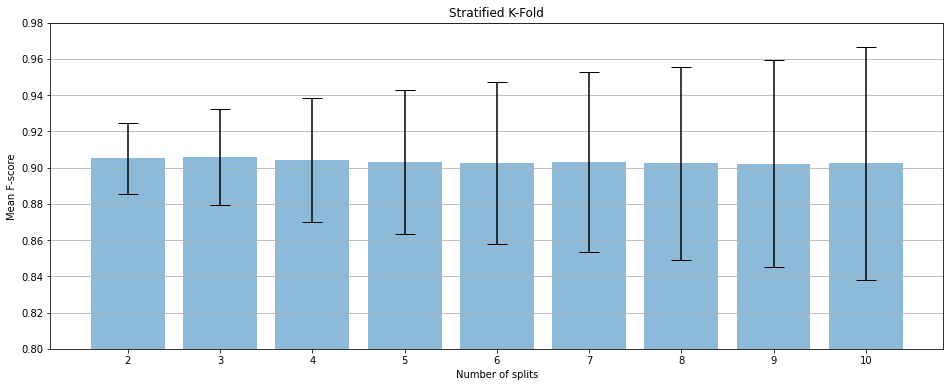

In [17]:
k_splits = list(range(2, 11))
results, errors = evaluate_cross_validation(model_gnb, X, y, StratifiedKFold, k_splits)

_, ax = plt.subplots(figsize=(16, 6))
ax.bar(k_splits, results,
       yerr=errors,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Mean F-score')
ax.set_xlabel('Number of splits')
ax.set_xticks(k_splits)
ax.set_xticklabels(k_splits)
ax.set_ylim(.8, 0.98)
ax.set_title('Stratified K-Fold')
ax.yaxis.grid(True)
plt.savefig('plots/seeds_stratified_kfold_results.png')

## Discretization

In [18]:
model = MultinomialNB()
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
r = evaluation_all_features(dataset, feature_names, feature_names, class_column_name, model,
                            skfold, list(range(3, 16)), ['uniform', 'quantile', 'kmeans'])

data = pd.DataFrame(r, columns=['Number of bins', 'Strategy', 'F-score'])

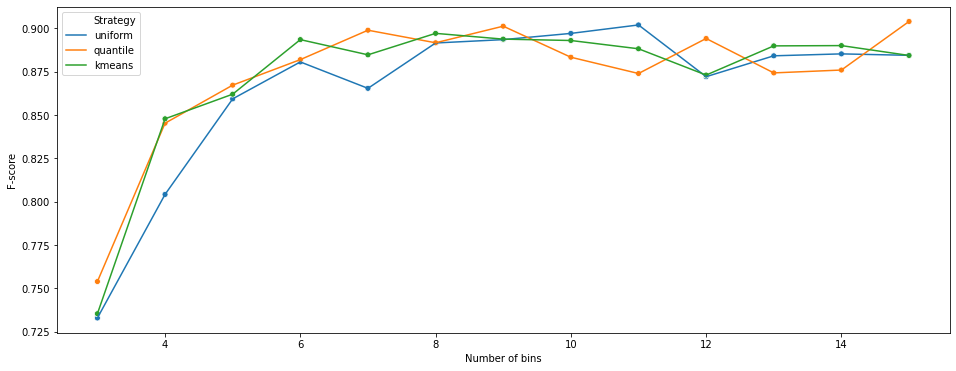

In [19]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x="Number of bins", y="F-score", hue='Strategy', data=data, legend=None)
sns.lineplot(x="Number of bins", y="F-score", hue='Strategy', data=data)
plt.savefig('plots/seeds_discretiztion_bin_strategy.png')

In [20]:
df = discretize_dataset(dataset, feature_names, n_bins=11, strategy='uniform')
df[feature_names].describe()

Area   Perimeter  Compactness  Length of kernel  Width of kernel  \
count  205.000000  205.000000   205.000000        205.000000       205.000000   
mean     3.887805    4.390244     5.814634          4.063415         4.453659   
std      3.034459    2.961171     2.362862          2.744134         2.952906   
min      0.000000    0.000000     0.000000          0.000000         0.000000   
25%      1.000000    2.000000     4.000000          2.000000         2.000000   
50%      3.000000    4.000000     6.000000          3.000000         4.000000   
75%      7.000000    7.000000     7.000000          6.000000         7.000000   
max     10.000000   10.000000    10.000000         10.000000        10.000000   

       Asymmetry coefficient  Length of kernel groove  
count             205.000000               205.000000  
mean                3.697561                 4.297561  
std                 2.138866                 2.705159  
min                 0.000000                 0.000000  
25%                 2.000000                 2.000000  
50%                 4.000000                 3.000000  
75%                 5.000000                 7.000000  
max                10.000000                10.000000

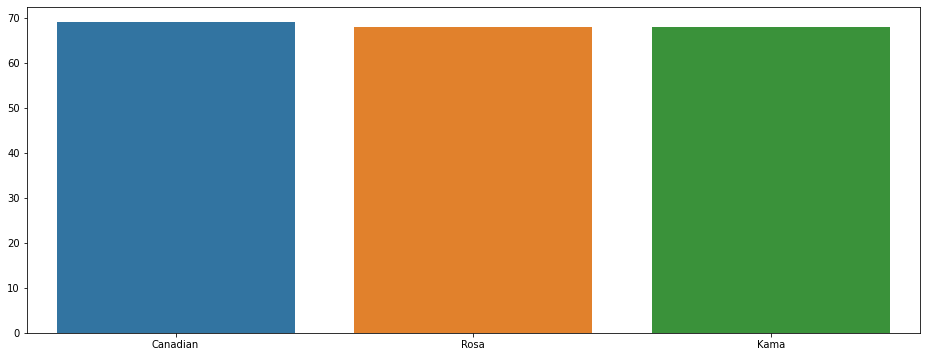

In [21]:
df_class_counts = df[class_column_name].value_counts()
plt.figure(figsize=(16, 6))
sns.barplot(df_class_counts.index, df_class_counts.values)
plt.savefig('plots/seeds_class_dist_after_discretization.png')

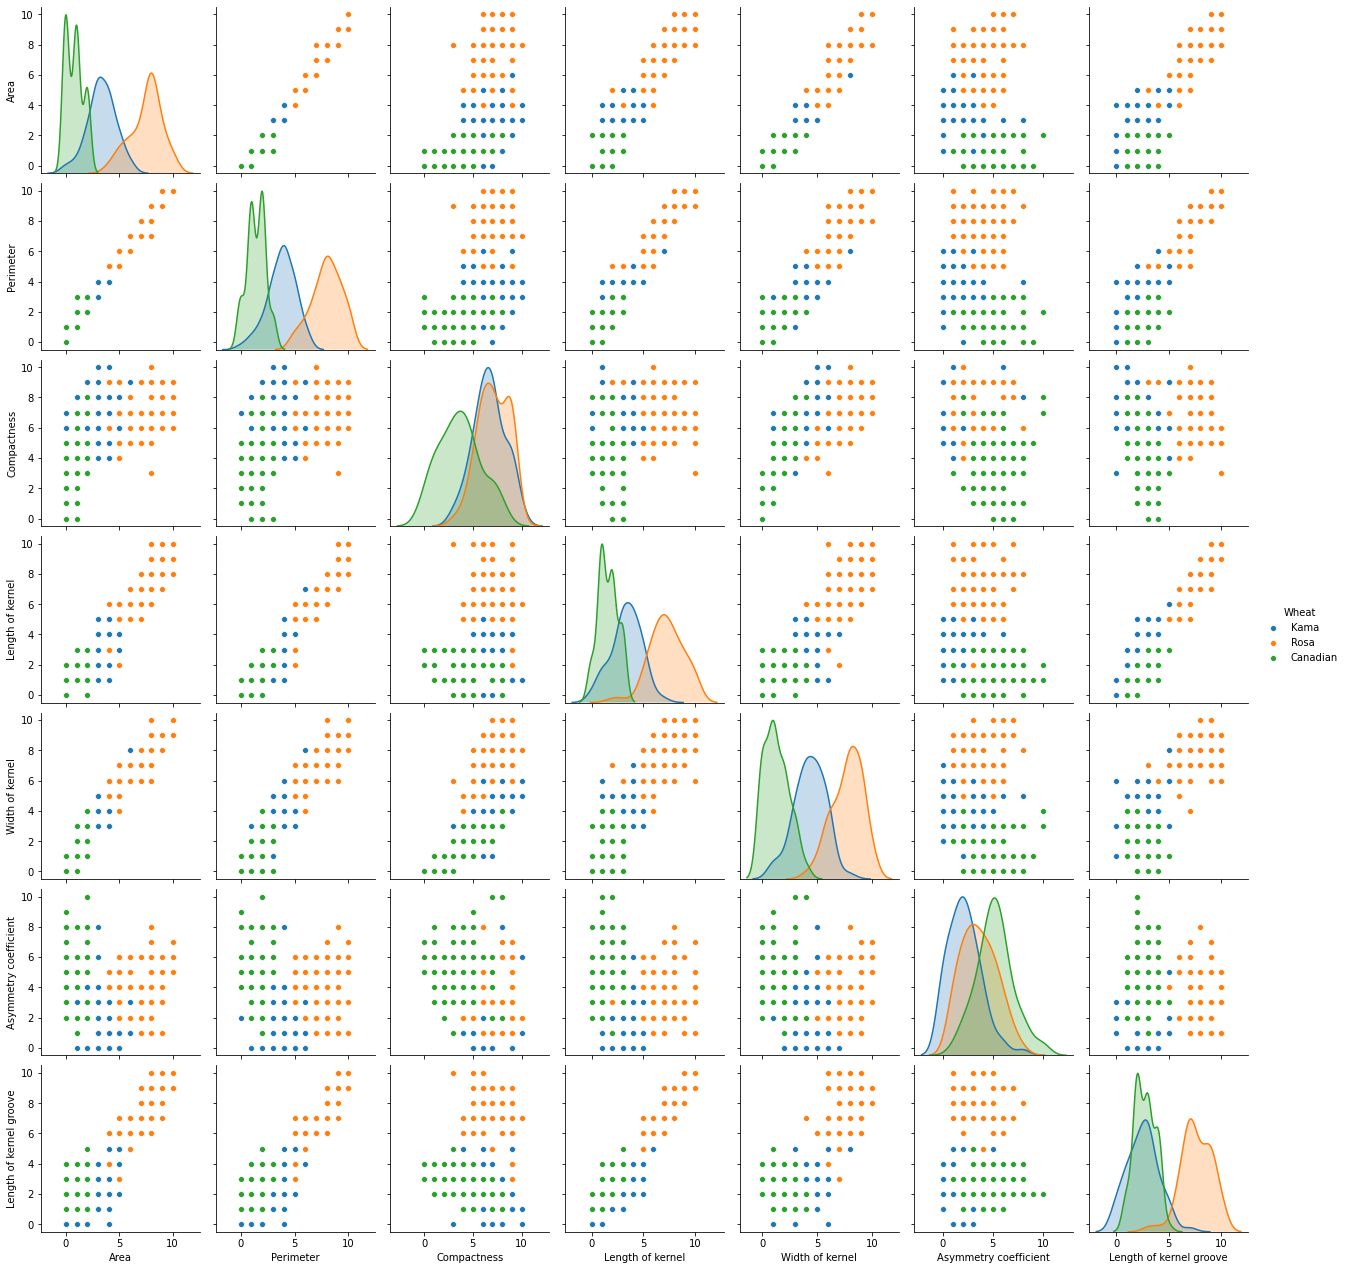

In [22]:
sns.pairplot(df, hue=class_column_name, vars=feature_names)
plt.savefig('plots/seeds_pairplot_after_discretization.png')

In [23]:
X, y = df[feature_names].to_numpy(), df['y'].to_numpy()
X = OneHotEncoder().fit_transform(X)

model_mnb = MultinomialNB()

sk_fold = StratifiedKFold(n_splits=5, random_state=3, shuffle=True)
y_pred = cross_val_predict(model_mnb, X, y, cv=sk_fold)

print_score(y, y_pred)

Acc:           0.9024390243902439
f1 avg:        0.9018166742047339
Recall avg:    0.9021739130434782
Precision avg: 0.9031818181818182
Recall:        [0.82352941 0.92647059 0.95652174]
Precision:     [0.875      0.95454545 0.88      ]
f1:            [0.84848485 0.94029851 0.91666667]
Confusion matrix:
[[56  3  9]
 [ 5 63  0]
 [ 3  0 66]]
